In [2]:
import os
import io
import requests
import time
import boto3
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
font = {'weight': 'bold'
       ,'size': 16}
plt.rc('font', **font)
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error,r2_score, make_scorer, roc_auc_score
from sklearn.metrics import roc_curve, auc, recall_score
from matplotlib.ticker import PercentFormatter, StrMethodFormatter

In [3]:
def poll_job(s, redash_url, job):
    while job['status'] not in (3,4):
        response = s.get('{}/api/jobs/{}'.format(redash_url, job['id']))
        job = response.json()['job']
        time.sleep(1)

    if job['status'] == 3:
        return job['query_result_id']
    
    return None

In [4]:
def get_fresh_query_result(redash_url, query_id, api_key, params):
    s = requests.Session()
    s.headers.update({'Authorization': 'Key {}'.format(api_key)})

    response = s.post('{}/api/queries/{}/refresh'.format(redash_url, query_id), params=params)

    if response.status_code != 200:
        raise Exception('Refresh failed.')

    result_id = poll_job(s, redash_url, response.json()['job'])

    if result_id:
        response = s.get('{}/api/queries/{}/results/{}.json'.format(redash_url, query_id, result_id))
        if response.status_code != 200:
            raise Exception('Failed getting results.')
    else:
        raise Exception('Query execution failed.')

    return response.json()['query_result']['data']['rows']

In [24]:
params = {'p_param': ''}
churn_query_id = 714507
api_key = os.environ['REDASH_API_KEY']
link = os.environ['REDASH_LINK']
churn_query = get_fresh_query_result(link, churn_query_id, api_key, params)
churn_df = pd.DataFrame(churn_query)

In [25]:
churn_df.columns = [col.lower() for col in churn_df.columns.tolist()]
churn_df.signup_time_utc = pd.to_datetime(churn_df.signup_time_utc)
churn_df.last_order_time_utc = pd.to_datetime(churn_df.last_order_time_utc)
churn_df.first_order_delivered_on_time = churn_df.first_order_delivered_on_time.astype(bool)
churn_df['first_order_discount_percent'] = churn_df.first_order_discount_amount / churn_df.first_order_gmv
churn_date = pd.to_datetime('today').floor('D') - pd.Timedelta(days=30)
churn_df['churned_user'] = churn_df.last_order_time_utc.map(lambda x: True if x < churn_date else False)

In [26]:
real_cities = churn_df.city_name.sort_values().unique().tolist()
got_cities = ["King's Landing"
             ,"Braavos"
             ,"Qarth"
             ,"Old Valyria"
             ,"Volantis"
             ,"Asshai"
             ,"Meereen"
             ,"Astapor"
             ,"Old Ghis"
             ,"Oldtown"
             ,"Pentos"
             ,"Qohor"
             ,"Sathar"
             ,"Sunspear"
             ,"Lannisport"
             ,"Vaes Dothrak"
             ,"White Harbor"
             ,"Yunkai"
             ,"The Wall"
             ,"Ghozi"
             ,"Gulltown"
             ,"Lys"
             ,"Mantarys"
             ,"Tyria"
             ,"Tolos"
             ,"Samyrian"
             ,"Oros"
             ,"Norvos"]
got_cities.sort()
city_dict = dict(zip(real_cities, got_cities))
churn_df.city_name = churn_df.city_name.map(city_dict)

In [27]:
kde_columns = churn_df.select_dtypes(include=[np.number, 'boolean']).drop('user_id', axis=1)
target = kde_columns.pop('churned_user')
values = kde_columns.iloc[:,0]
values[target == False]

0          375.266667
2         2540.783333
3          156.616667
4         2438.400000
5         1156.750000
             ...     
171742    4998.683333
171758    4009.233333
171780       1.166667
171817     526.616667
171821       0.783333
Name: signup_to_order_hours, Length: 39828, dtype: float64

In [28]:
kde_data = churn_df.select_dtypes(include=[np.number, 'boolean']).drop('user_id', axis=1)
kde_cols = kde_data.iloc[:,:kde_data.shape[1] - 1].columns.to_list()

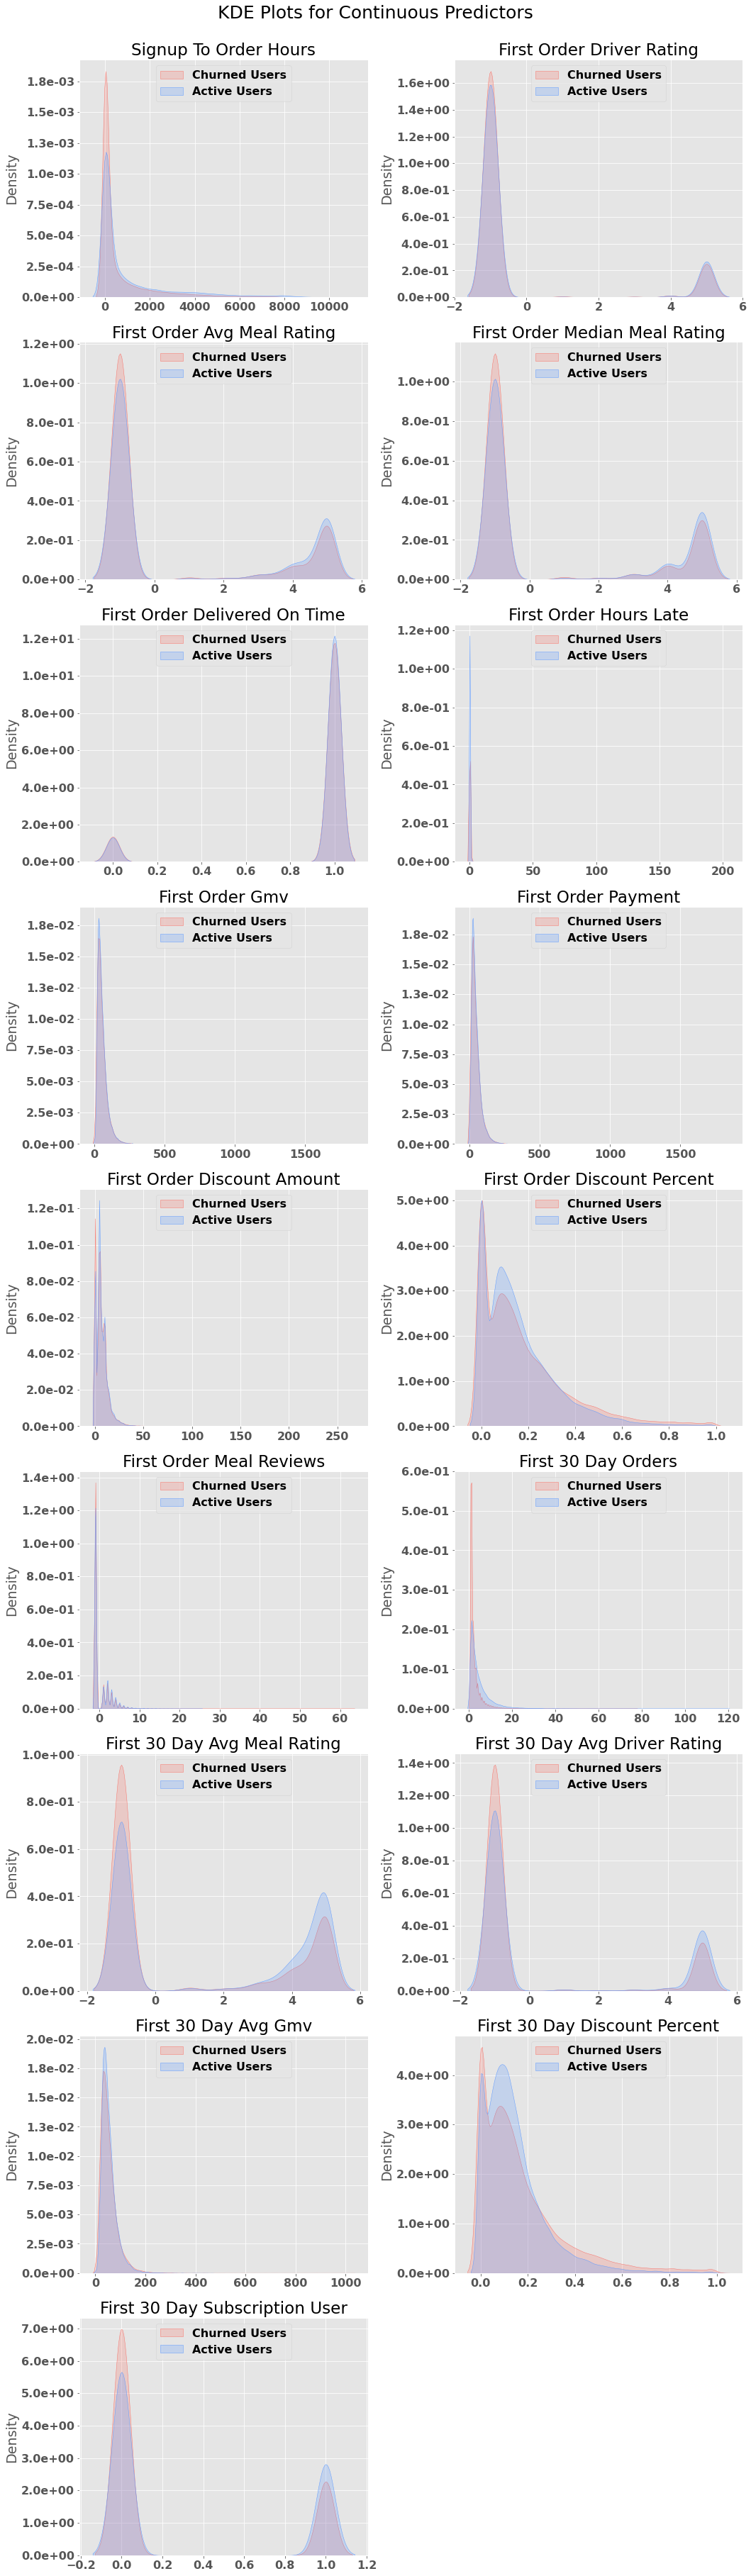

In [34]:
fig, axs = plt.subplots(nrows=np.ceil(len(kde_cols)/2).astype(int), ncols=2, figsize=(15,50))

for col, ax in zip(kde_cols[:len(kde_cols)], axs.flatten()):
    
    churn = kde_data[kde_data.churned_user == True]
    active = kde_data[kde_data.churned_user == False]

    sns.kdeplot(churn[col], fill=True, bw_method=0.1, color='#F8766D', label='Churned Users', ax=ax)
    sns.kdeplot(active[col], fill=True, bw_method=0.1, color='#619CFF', label='Active Users', ax=ax)
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1e}'))
    ax.set_title(col.replace('_', ' ').title())
    ax.legend(loc='upper center')

if len(kde_cols) % 2 == 1:
    fig.delaxes(axs[np.ceil(len(kde_cols)/2).astype(int)-1,1])
    
plt.tight_layout()
_ = plt.suptitle("KDE Plots for Continuous Predictors",y=1.01, fontsize=25)
# plt.savefig()

In [60]:
categorical_data = churn_df.select_dtypes(include=['object'])
categorical_data = pd.concat([categorical_data, churn_df.churned_user], axis=1)
len(categorical_data.columns.tolist()[:-1])

2

In [11]:
cat_data = churn_df[['city_name', 'city_group', 'churned_user']]
cat_cols = cat_data.iloc[:,:cat_data.shape[1] - 1].columns.to_list()

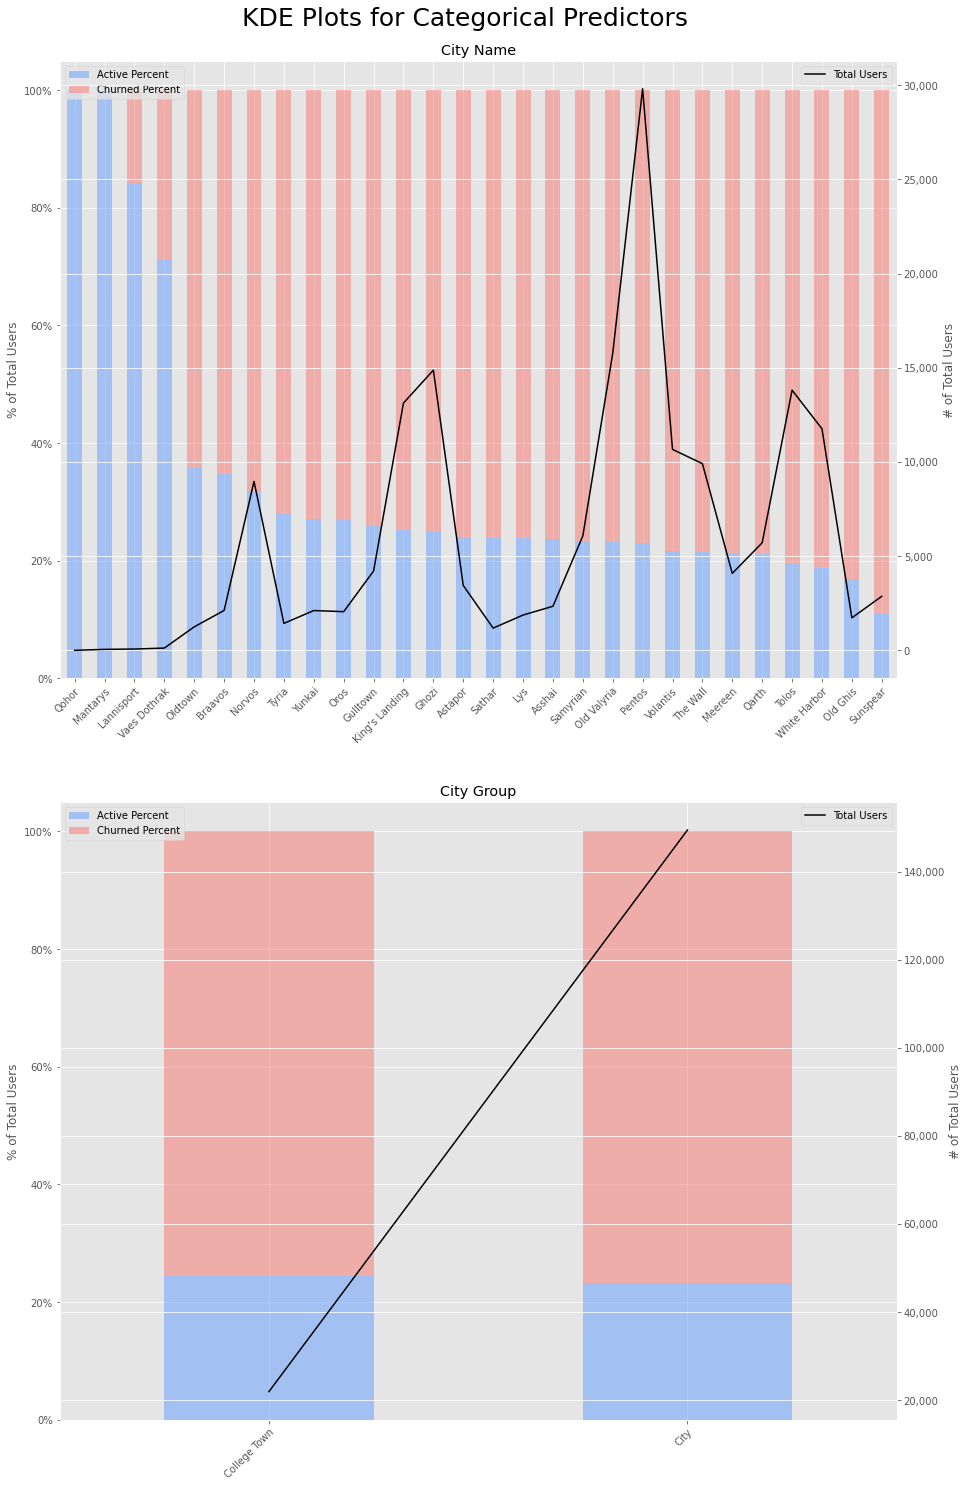

In [12]:
fig, axs = plt.subplots(nrows=np.ceil(len(cat_cols)).astype(int), ncols=1, figsize=(15,25))

for col, ax in zip(cat_cols[:len(cat_cols)], axs.flatten()):

    group_data = cat_data.groupby([col, 'churned_user']).size().unstack()
    group_data.columns = ['Active Users', 'Churned Users']
    group_data = group_data.fillna(value=0)
    group_data['Total Users'] = group_data['Active Users'] + group_data['Churned Users']
    group_data['Active Percent'] = group_data['Active Users'] / group_data['Total Users']
    group_data['Churned Percent'] = group_data['Churned Users'] / group_data['Total Users']
    total_users = group_data.sort_values('Active Percent', ascending=False)['Total Users']
    city_churn = group_data[['Active Percent', 'Churned Percent']].sort_values('Active Percent', ascending=False)
    city_churn.plot.bar(stacked=True, ax=ax, color=['#619CFF', '#F8766D'], alpha = 0.5)
    ax2 = ax.twinx()
    total_users.plot(color='black', ax=ax2)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode="anchor")
    ax.set_xlabel('')
    ax.set_title(col.replace('_', ' ').title())
    ax.set_ylabel('% of Total Users')
    ax2.set_ylabel('# of Total Users')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

_ = plt.suptitle("KDE Plots for Categorical Predictors",y=0.91, fontsize=25)

In [19]:
y = churn_df.pop('churned_user')
X = churn_df

In [20]:
churn_data_Xy = pd.concat([X, y], axis=1)
churn_train, churn_test = train_test_split(churn_data_Xy, test_size=0.2, shuffle=True, stratify=y)

In [21]:
churn_train.to_csv('churn_train.csv', index=False)

In [10]:
aws_id = os.environ['AWS_ACCESS_KEY_ID']
aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']
client = boto3.client('s3'
                     ,aws_access_key_id=aws_id
                     ,aws_secret_access_key=aws_secret)
client.upload_file(Filename='churn_train.csv', Bucket='food-delivery-churn', Key='churn_train.csv')

In [11]:
train_obj = client.get_object(Bucket='food-delivery-churn', Key='churn_train.csv')
churn_train_X = pd.read_csv(io.BytesIO(train_obj['Body'].read())
                            ,encoding='utf8'
                            ,parse_dates=['signup_time_utc', 'last_order_time_utc']
                            ,date_parser=pd.to_datetime)